In [5]:
# pip install parzenpy

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from parzenpy.parzen_smooth import parzenpy
import scipy as sp

# Example of applying Parzen smoothing to an entire record of microtremor data

In this example smoothing is applied to waveform data.

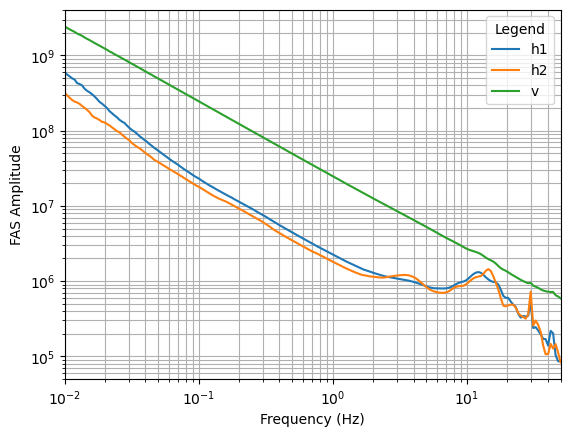

CPU times: total: 8.75 s
Wall time: 9.76 s


In [5]:
%%time

#Specify directory where files are stored
directory = r'C:\Users\Javier Ornelas\OneDrive\Documents\HVSRdata_Main\mHVSR Site Inv\VSPDB Data\CA Vertical Array Data\HVSRdata\2\2.250.2\Text_File_data\Raw_ascii_PEG_HH'

#Read each coomponent of waveform data
H1 = pd.read_csv(os.path.join(directory,'20220907170054_NX_USC6_HHN.txt'),sep=' ',header=None)[1].values
H2 = pd.read_csv(os.path.join(directory,'20220907170058_NX_USC6_HHE.txt'),sep=' ',header=None)[1].values
V = pd.read_csv(os.path.join(directory,'20220907170100_NX_USC6_HHZ.txt'),sep=' ',header=None)[1].values

#Specify time step
dt = 0.005

#Specify resampling frequency array
fc = np.logspace(-2,np.log10(50),200)

#Truncate data to the minimum number of points (N)
N = np.min([len(H1), len(H2), len(V)])
H1 = H1[:N]
H2 = H2[:N]
V = V[:N]

#Compute the frequency component of the record
freq = np.fft.rfftfreq(N,dt)

#Perform fft on each component
h1_fft = np.fft.rfft(H1)
h2_fft = np.fft.rfft(H2)
v_fft = np.fft.rfft(V)

#Initialize the smoothing function
h1 = parzenpy(freq=freq,fft=h1_fft)
h2 = parzenpy(freq=freq,fft=h2_fft)
v = parzenpy(freq=freq,fft=v_fft)

#Smooth each component
smooth_fash1 = h1.apply_smooth(fc = fc, windowed_flag=False)
smooth_fash2 = h2.apply_smooth(fc = fc, windowed_flag=False)
smooth_fasv = v.apply_smooth(fc = fc, windowed_flag=False)

#Plot the smoothed data
plt.loglog(fc,smooth_fash1, label = 'H1')
plt.loglog(fc,smooth_fash2, label = 'H2')
plt.loglog(fc,smooth_fasv, label = 'V')

plt.xlim(0.01,50)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Fourier Amplitude')

plt.legend(title = 'Legend', fancybox = True)

plt.grid(True,which = 'both')

plt.show()

# Example of applying Parzen smoothing to a windowed microtremor data

In this example, waveform data is preprocessed and then windowed into individual discrete time windows. The data is then smoothed and plotted.

CPU times: total: 3.34 s
Wall time: 5.77 s


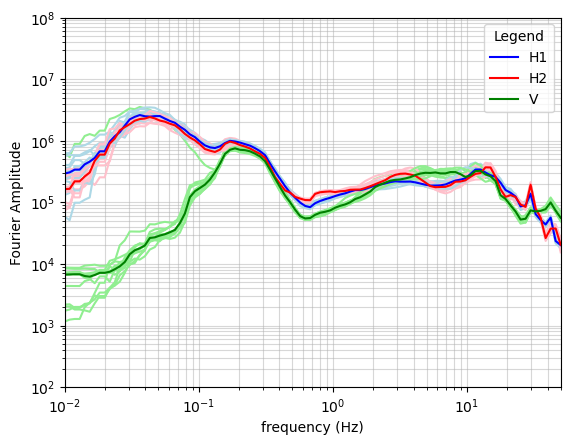

In [6]:
%%time

#Specify directory where files are stored 
directory = r'C:\Users\Javier Ornelas\OneDrive\Documents\HVSRdata_Main\mHVSR Site Inv\VSPDB Data\CA Vertical Array Data\HVSRdata\2\2.250.2\Text_File_data\Raw_ascii_PEG_HH'

#Read each coomponent of waveform data
H1 = pd.read_csv(os.path.join(directory,'20220907170054_NX_USC6_HHN.txt'),sep=' ',header=None)[1].values
H2 = pd.read_csv(os.path.join(directory,'20220907170058_NX_USC6_HHE.txt'),sep=' ',header=None)[1].values
V = pd.read_csv(os.path.join(directory,'20220907170100_NX_USC6_HHZ.txt'),sep=' ',header=None)[1].values

#Specify time step
dt = 0.005

#Specify window length
Lwin = 300

#Specify resampling frequency array
fc = np.logspace(-2,np.log10(50),100)

#Truncate data to the minimum number of points (N)
N = np.min([len(H1), len(H2), len(V)])

#Compute how many windows 
Nwin = int(np.floor(N*dt/Lwin))

#Compute the number of points per window
N_per_window = int(np.floor(Lwin/dt))

#Compute the frequency component of the record
f = np.fft.rfftfreq(N,dt)

#Specify high-pass filtering parameters
hp = np.zeros(len(f))
fchp = 0.042
hp_order = 5.0

#Apply a Tukey Windowing function w/ wieghted mean detrend
taper = sp.signal.windows.tukey(N, 0.05)

H1_taper = H1[0:N] * taper - np.average(H1[0:N], weights=taper)
H2_taper = H2[0:N] * taper - np.average(H2[0:N], weights=taper)
V_taper = V[0:N] * taper - np.average(V[0:N], weights=taper)

#Perfrom fft on each component
FH1_taper = np.fft.rfft(H1_taper)
FH2_taper = np.fft.rfft(H2_taper)
FV_taper = np.fft.rfft(V_taper)

#Apply high-pass butterworth filter to data
hp[f>0] = 1 / np.sqrt(1 + (fchp / f[f>0])**(2.0 * hp_order))

FH1_filt = FH1_taper*hp
FH2_filt = FH2_taper*hp
FV_filt = FV_taper*hp

#Invert the processed data to revert back to time-domain
H1_filt = np.fft.irfft(FH1_filt)
H2_filt = np.fft.irfft(FH2_filt)
V_filt = np.fft.irfft(FV_filt)

#Separate the processed data into individual time windows
H1_win = np.reshape(H1_filt[0:Nwin*N_per_window],(Nwin,N_per_window))
H2_win = np.reshape(H2_filt[0:Nwin*N_per_window],(Nwin,N_per_window))
V_win = np.reshape(V_filt[0:Nwin*N_per_window],(Nwin,N_per_window))

#Apply a Tukey windowing function and weighted mean detrend to each window
taper = sp.signal.windows.tukey(N_per_window, 0.05)

H1_win_taper = H1_win * taper - np.average(H1_win, axis=1, weights=taper)[:, np.newaxis]
H2_win_taper = H2_win * taper - np.average(H2_win, axis=1, weights=taper)[:, np.newaxis]
V_win_taper = V_win * taper - np.average(V_win, axis=1, weights=taper)[:, np.newaxis]

#Perform fft to each component 
FH1_win_taper = np.fft.rfft(H1_win_taper)
FH2_win_taper = np.fft.rfft(H2_win_taper)
FV_win_taper = np.fft.rfft(V_win_taper)

#Compute the freq component of each windowed fft
f_win = np.fft.rfftfreq(N_per_window, dt)

#Initialize the smoothing function
h1 = parzenpy(freq=f_win,fft=FH1_win_taper)
h2 = parzenpy(freq=f_win,fft=FH2_win_taper)
v = parzenpy(freq=f_win,fft=FV_win_taper)

#Apply the smoothing function to all components
smooth_fash1 = h1.apply_smooth(fc = fc, windowed_flag=True)
smooth_fash2 = h2.apply_smooth(fc = fc, windowed_flag=True)
smooth_fasv = v.apply_smooth(fc = fc, windowed_flag=True)

#Compute the mean for each component
mean_h1 = np.median(smooth_fash1,axis =0)
mean_h2 = np.median(smooth_fash2, axis =0)
mean_v = np.median(smooth_fasv, axis =0)

#Plot the data
fig, ax = plt.subplots()

#Plot the smoothed FAS for each component
for i in range(Nwin):
    ax.loglog(fc,smooth_fash1[i],color = 'lightblue')
    ax.loglog(fc,smooth_fash2[i],color = 'pink')
    ax.loglog(fc,smooth_fasv[i],color = 'lightgreen')

#Plot the mean FAS for each component
ax.loglog(fc,mean_h1,color ='blue', label = 'H1')
ax.loglog(fc,mean_h2, color = 'red', label = 'H2')
ax.loglog(fc,mean_v, color ='green', label = 'V')

ax.grid(True, alpha=0.5, which='both')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Fourier Amplitude')

ax.set_xlim(0.01,50)
ax.set_ylim(10e1,10e7)

ax.legend(title='Legend')